## Eindopdracht Machine Learning

In deze notebook gaan we aan de slag met de voorspellingen en het onderzoek van de suzuki fruitvlieg.
We willen aantonen ofdat er bepalende weerfactoren zijn binnen de suzuki fruitvlieg. Denk hierbij aan Max en Min temperatuur, Windsnelheid en luchtvochtigheid.
Deze willen we gaan coreleren met de fruitvlieg en kijken of deze correlatie hebben tussen elkaar.

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestRegressor

from math import radians, cos, sin, asin, sqrt

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)
print('matplotlib version:', matplotlib.__version__)

%matplotlib inline

numpy version: 1.11.2
pandas version: 0.18.1
scikit-learn version: 0.17.1
matplotlib version: 1.5.1


YYYYMMDD = Datum (YYYY=jaar MM=maand DD=dag)
DDVEC    = Vectorgemiddelde windrichting in graden (360=noord, 90=oost, 180=zuid, 270=west, 0=windstil/variabel). Zie http://www.knmi.nl/kennis-en-datacentrum/achtergrond/klimatologische-brochures-en-boeken
FHVEC    = Vectorgemiddelde windsnelheid (in 0.1 m/s). Zie http://www.knmi.nl/kennis-en-datacentrum/achtergrond/klimatologische-brochures-en-boeken 
FG       = Etmaalgemiddelde windsnelheid (in 0.1 m/s) 
FHX      = Hoogste uurgemiddelde windsnelheid (in 0.1 m/s) 
FHXH     = Uurvak waarin FHX is gemeten
FHN      = Laagste uurgemiddelde windsnelheid (in 0.1 m/s)
FHNH     = Uurvak waarin FHN is gemeten
FXX      = Hoogste windstoot (in 0.1 m/s)
FXXH     = Uurvak waarin FXX is gemeten
TG       = Etmaalgemiddelde temperatuur (in 0.1 graden Celsius)
TN       = Minimum temperatuur (in 0.1 graden Celsius)
TNH      = Uurvak waarin TN is gemeten
TX       = Maximum temperatuur (in 0.1 graden Celsius)
TXH      = Uurvak waarin TX is gemeten
T10N     = Minimum temperatuur op 10 cm hoogte (in 0.1 graden Celsius)
T10NH    = 6-uurs tijdvak waarin T10N is gemeten; 6=0-6 UT, 12=6-12 UT, 18=12-18 UT, 24=18-24 UT
SQ       = Zonneschijnduur (in 0.1 uur) berekend uit de globale straling (-1 voor <0.05 uur)
SP       = Percentage van de langst mogelijke zonneschijnduur
Q        = Globale straling (in J/cm2)
DR       = Duur van de neerslag (in 0.1 uur)
RH       = Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)
RHX      = Hoogste uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)
RHXH     = Uurvak waarin RHX is gemeten
PG       = Etmaalgemiddelde luchtdruk herleid tot zeeniveau (in 0.1 hPa) berekend uit 24 uurwaarden
PX       = Hoogste uurwaarde van de luchtdruk herleid tot zeeniveau (in 0.1 hPa)
PXH      = Uurvak waarin PX is gemeten
PN       = Laagste uurwaarde van de luchtdruk herleid tot zeeniveau (in 0.1 hPa)
PNH      = Uurvak waarin PN is gemeten
VVN      = Minimum opgetreden zicht; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km)
VVNH     = Uurvak waarin VVN is gemeten
VVX      = Maximum opgetreden zicht; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km)
VVXH     = Uurvak waarin VVX is gemeten
NG       = Etmaalgemiddelde bewolking (bedekkingsgraad van de bovenlucht in achtsten, 9=bovenlucht onzichtbaar); 
UG       = Etmaalgemiddelde relatieve vochtigheid (in procenten)
UX       = Maximale relatieve vochtigheid (in procenten)
UXH      = Uurvak waarin UX is gemeten
UN       = Minimale relatieve vochtigheid (in procenten)
UNH      = Uurvak waarin UN is gemeten
EV24     = Referentiegewasverdamping (Makkink) (in 0.1 mm)

In [2]:
df_weer = pd.read_csv("KNMI_WEER_2.txt", sep=",")
print(df_weer.shape)
df_weer.head()

(571742, 41)


,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,210,19510101,202.0,93.0,108.0,190.0,17.0,51.0,23.0,NaN,...,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
1,210,19510102,155.0,51.0,51.0,113.0,2.0,15.0,24.0,NaN,...,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2,210,19510103,208.0,15.0,21.0,51.0,22.0,0.0,3.0,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,210,19510104,207.0,93.0,93.0,134.0,13.0,51.0,1.0,NaN,...,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
4,210,19510105,222.0,103.0,108.0,154.0,21.0,51.0,24.0,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#KNMI dataset filteren op datum alles vanaf 2014 tot 2015 de rest mag weg
df_weer_transformed = df_weer[(df_weer['YYYYMMDD'] >= 20141016)&(df_weer['YYYYMMDD'] <= 20151016)]
print(df_weer_transformed.shape)
df_weer_transformed.head(10)

(11592, 41)


,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
20527,210,20141016,212.0,35.0,43.0,80.0,14.0,20.0,24.0,120.0,...,4.0,75.0,13.0,6.0,91.0,97.0,3.0,77.0,13.0,11.0
20528,210,20141017,213.0,31.0,37.0,80.0,12.0,10.0,3.0,120.0,...,6.0,75.0,15.0,5.0,91.0,98.0,1.0,80.0,14.0,11.0
20529,210,20141018,174.0,47.0,49.0,70.0,13.0,30.0,1.0,110.0,...,1.0,75.0,10.0,3.0,81.0,94.0,1.0,70.0,15.0,15.0
20530,210,20141019,227.0,77.0,80.0,110.0,11.0,40.0,1.0,180.0,...,19.0,75.0,9.0,5.0,85.0,92.0,3.0,77.0,10.0,9.0
20531,210,20141020,251.0,80.0,81.0,100.0,1.0,60.0,21.0,160.0,...,21.0,75.0,4.0,7.0,78.0,87.0,21.0,72.0,18.0,10.0
20532,210,20141021,271.0,76.0,106.0,150.0,22.0,60.0,2.0,230.0,...,10.0,75.0,1.0,7.0,80.0,97.0,10.0,59.0,24.0,4.0
20533,210,20141022,314.0,88.0,90.0,140.0,1.0,30.0,22.0,230.0,...,2.0,82.0,17.0,7.0,72.0,86.0,2.0,62.0,17.0,8.0
20534,210,20141023,214.0,49.0,53.0,70.0,13.0,30.0,8.0,130.0,...,20.0,75.0,13.0,8.0,81.0,90.0,7.0,70.0,11.0,6.0
20535,210,20141024,187.0,57.0,58.0,70.0,4.0,50.0,13.0,110.0,...,16.0,70.0,3.0,8.0,94.0,97.0,16.0,82.0,3.0,2.0
20536,210,20141025,228.0,25.0,31.0,60.0,15.0,10.0,5.0,90.0,...,6.0,80.0,15.0,7.0,85.0,99.0,6.0,69.0,15.0,5.0


In [4]:
#KNMI dataset NAN en Null filteren
df_weer_transformed = df_weer_transformed.dropna()
df_weer_transformed = df_weer_transformed.drop_duplicates()
print(df_weer_transformed.shape)

(5242, 41)


In [5]:
#Vliegen dataset inladen
df_vlieg = pd.read_csv('BWB_DS_monitoring.csv', header = 0, sep = '~')
df_vlieg.sort('datum')
df_vlieg.head(10)

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,datum,aantal,fruitsoort,lat,lon
4,2015-08-01,0,druif,52.348315,5.217563
18,2015-07-16,0,druif,52.198608,6.007211
19,2015-07-01,0,druif,52.198608,6.007211
24,2015-08-01,0,druif,52.198608,6.007211
35,2015-07-01,0,druif,51.414131,3.821260
36,2015-08-01,0,druif,51.414131,3.821260
38,2015-07-16,0,druif,51.414131,3.821260
43,2015-07-01,3,druif,52.113207,6.227103
46,2015-09-16,61,druif,52.113207,6.227103
56,2015-07-01,0,druif,51.495140,6.091085


In [6]:
fruitsoort = df_vlieg['fruitsoort'].unique()
fruitsoort

array(['druif', 'kers', 'appel', 'kleinfruit', 'peer'], dtype=object)

In [7]:
#colommen maken voor de verschillende soorten fruit met 0 en 1 (0 is niet aanwezig, 1 is wel aanwezig)
for x in fruitsoort:
    df_vlieg[x] = [1 if x == y else 0 for y in df_vlieg["fruitsoort"]]
    
df_vlieg

,datum,aantal,fruitsoort,lat,lon,druif,kers,appel,kleinfruit,peer
4,2015-08-01,0,druif,52.348315,5.217563,1,0,0,0,0
18,2015-07-16,0,druif,52.198608,6.007211,1,0,0,0,0
19,2015-07-01,0,druif,52.198608,6.007211,1,0,0,0,0
24,2015-08-01,0,druif,52.198608,6.007211,1,0,0,0,0
35,2015-07-01,0,druif,51.414131,3.821260,1,0,0,0,0
36,2015-08-01,0,druif,51.414131,3.821260,1,0,0,0,0
38,2015-07-16,0,druif,51.414131,3.821260,1,0,0,0,0
43,2015-07-01,3,druif,52.113207,6.227103,1,0,0,0,0
46,2015-09-16,61,druif,52.113207,6.227103,1,0,0,0,0
56,2015-07-01,0,druif,51.495140,6.091085,1,0,0,0,0


In [8]:
#weer dataset de datums in dagen manden en jaren transformeren
df_weer_transformed["dag"] = [str(x)[6:] for x in df_weer_transformed["YYYYMMDD"]]
df_weer_transformed["maand"] = [str(x)[4:6] for x in df_weer_transformed["YYYYMMDD"]]
df_weer_transformed["jaar"] = [str(x)[:4] for x in df_weer_transformed["YYYYMMDD"]]
df_weer_transformed.head()

,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,NG,UG,UX,UXH,UN,UNH,EV24,dag,maand,jaar
20527,210,20141016,212.0,35.0,43.0,80.0,14.0,20.0,24.0,120.0,...,6.0,91.0,97.0,3.0,77.0,13.0,11.0,16,10,2014
20528,210,20141017,213.0,31.0,37.0,80.0,12.0,10.0,3.0,120.0,...,5.0,91.0,98.0,1.0,80.0,14.0,11.0,17,10,2014
20529,210,20141018,174.0,47.0,49.0,70.0,13.0,30.0,1.0,110.0,...,3.0,81.0,94.0,1.0,70.0,15.0,15.0,18,10,2014
20530,210,20141019,227.0,77.0,80.0,110.0,11.0,40.0,1.0,180.0,...,5.0,85.0,92.0,3.0,77.0,10.0,9.0,19,10,2014
20531,210,20141020,251.0,80.0,81.0,100.0,1.0,60.0,21.0,160.0,...,7.0,78.0,87.0,21.0,72.0,18.0,10.0,20,10,2014


In [9]:
#vlieg dataset de datums in dagen maanden en jaren transformeren
df_vlieg["dag"] = [str(x)[8:] for x in df_vlieg["datum"]]
df_vlieg["maand"] = [str(x)[5:7] for x in df_vlieg["datum"]]
df_vlieg["jaar"] = [str(x)[:4] for x in df_vlieg["datum"]]
df_vlieg["meting_id"] = range(0,len(df_vlieg))
df_vlieg_original = df_vlieg.copy()
df_vlieg.head()

,datum,aantal,fruitsoort,lat,lon,druif,kers,appel,kleinfruit,peer,dag,maand,jaar,meting_id
4,2015-08-01,0,druif,52.348315,5.217563,1,0,0,0,0,01,08,2015,0
18,2015-07-16,0,druif,52.198608,6.007211,1,0,0,0,0,16,07,2015,1
19,2015-07-01,0,druif,52.198608,6.007211,1,0,0,0,0,01,07,2015,2
24,2015-08-01,0,druif,52.198608,6.007211,1,0,0,0,0,01,08,2015,3
35,2015-07-01,0,druif,51.414131,3.821260,1,0,0,0,0,01,07,2015,4


In [10]:
df_station = pd.read_csv("KNMI_STATIONS.txt", sep=",")
df_station.head(10)

,STN,LON(east),LAT(north),ALT(m),NAME
0,210,4.430,52.171,-0.2,VALKENBURG
1,215,4.437,52.141,-1.1,VOORSCHOTEN
2,225,4.555,52.463,4.4,IJMUIDEN
3,235,4.781,52.928,1.2,DEKOOY
4,240,4.790,52.318,-3.3,SCHIPHOL
5,242,4.921,53.241,10.8,VLIELAND
6,249,4.979,52.644,-2.4,BERKHOUT
7,251,5.346,53.392,0.7,HOORN(TERSCHELLING)
8,257,4.603,52.506,8.5,WIJKAANZEE
9,258,5.401,52.649,7.3,HOUTRIBDIJK


In [11]:
#Weer stations koppelen aan de gemete weer station data zodat je de locatie hebt van de meting
#zo kan je berekenen hoever de meting van de vliegdata af ligt
df_weer_transformed = pd.merge(df_weer_transformed, df_station, on='STN', how='outer')
df_weer_transformed.head()

,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,UN,UNH,EV24,dag,maand,jaar,LON(east),LAT(north),ALT(m),NAME
0,210.0,20141016.0,212.0,35.0,43.0,80.0,14.0,20.0,24.0,120.0,...,77.0,13.0,11.0,16,10,2014,4.43,52.171,-0.2,VALKENBURG
1,210.0,20141017.0,213.0,31.0,37.0,80.0,12.0,10.0,3.0,120.0,...,80.0,14.0,11.0,17,10,2014,4.43,52.171,-0.2,VALKENBURG
2,210.0,20141018.0,174.0,47.0,49.0,70.0,13.0,30.0,1.0,110.0,...,70.0,15.0,15.0,18,10,2014,4.43,52.171,-0.2,VALKENBURG
3,210.0,20141019.0,227.0,77.0,80.0,110.0,11.0,40.0,1.0,180.0,...,77.0,10.0,9.0,19,10,2014,4.43,52.171,-0.2,VALKENBURG
4,210.0,20141020.0,251.0,80.0,81.0,100.0,1.0,60.0,21.0,160.0,...,72.0,18.0,10.0,20,10,2014,4.43,52.171,-0.2,VALKENBURG


In [12]:
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

def merge(row):
    lat = row["lat"]
    lon = row["lon"]
    jaar = row["jaar"]
    maand = row["maand"]
    dag = row["dag"]
    
    weer_data = df_weer_transformed[(df_weer_transformed["dag"] == dag) & (df_weer_transformed["maand"] == maand) & (df_weer_transformed["jaar"] == jaar)]
    if len(weer_data) > 0:
        weer_data["afstand"] = weer_data.apply(lambda x: haversine(lon, lat, x["LON(east)"], x["LAT(north)"]), axis=1)
        weer_row = weer_data[weer_data["afstand"] == min(weer_data["afstand"])]
        return pd.merge(pd.DataFrame().append(row), weer_row, on=["dag", "maand", "jaar"], how="outer").squeeze()
    
    
df_merged = df_vlieg.apply(merge, axis=1)
df_merged.head()

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,aantal,appel,dag,datum,druif,fruitsoort,jaar,kers,kleinfruit,lat,...,UX,UXH,UN,UNH,EV24,LON(east),LAT(north),ALT(m),NAME,afstand
4,0.0,0.0,01,2015-08-01,1.0,druif,2015,0.0,0.0,52.348315,...,94.0,5.0,42.0,13.0,38.0,5.520,52.458,-3.7,LELYSTAD,23.853730
18,0.0,0.0,16,2015-07-16,1.0,druif,2015,0.0,0.0,52.198608,...,97.0,5.0,50.0,14.0,49.0,5.873,52.056,48.2,DEELEN,18.302194
19,0.0,0.0,01,2015-07-01,1.0,druif,2015,0.0,0.0,52.198608,...,70.0,3.0,25.0,15.0,59.0,5.873,52.056,48.2,DEELEN,18.302194
24,0.0,0.0,01,2015-08-01,1.0,druif,2015,0.0,0.0,52.198608,...,93.0,24.0,40.0,11.0,40.0,5.873,52.056,48.2,DEELEN,18.302194
35,0.0,0.0,01,2015-07-01,1.0,druif,2015,0.0,0.0,51.414131,...,72.0,4.0,42.0,16.0,57.0,3.596,51.442,8.0,VLISSINGEN,15.911706


In [13]:
df_merged.columns

Index(['aantal', 'appel', 'dag', 'datum', 'druif', 'fruitsoort', 'jaar',
       'kers', 'kleinfruit', 'lat', 'lon', 'maand', 'meting_id', 'peer', 'STN',
       'YYYYMMDD', 'DDVEC', 'FHVEC', 'FG', 'FHX', 'FHXH', 'FHN', 'FHNH', 'FXX',
       'FXXH', 'TG', 'TN', 'TNH', 'TX', 'TXH', 'T10N', 'T10NH', 'SQ', 'SP',
       'Q', 'DR', 'RH', 'RHX', 'RHXH', 'PG', 'PX', 'PXH', 'PN', 'PNH', 'VVN',
       'VVNH', 'VVX', 'VVXH', 'NG', 'UG', 'UX', 'UXH', 'UN', 'UNH', 'EV24',
       'LON(east)', 'LAT(north)', 'ALT(m)', 'NAME', 'afstand'],
      dtype='object')

In [14]:
df_merged = df_merged.drop_duplicates()
df_merged = df_merged.dropna()

In [15]:
df_merged.shape

(501, 60)

In [16]:
df_merged['aanwezig'] = [1 if x > 0 else 0 for x in df_merged["aantal"]]
#Dit doen we om te laten zien of dat er vliegen aanwezig gaan zijn ja of nee.
#vanuit de aantal meeting die meegegeven is van de data kan je namelijk niet echt een stabiele conclussie trekken
#er wordt gesproken over een X aantal vliegen die aangetroffen zijn in de desbetreffende Val maar dat zegt NIKS over
#de mogelijke aanwezige vliegen die er buiten de val zijn. 
df_merged['voorspelling'] = df_merged['aantal']

df_merged['voorspelling'][df_merged['voorspelling'].between(0, 10)] = 0
df_merged['voorspelling'][df_merged['voorspelling'].between(10, 50)] = 1
df_merged['voorspelling'][df_merged['voorspelling'].between(50, 100)] = 2
df_merged['voorspelling'][df_merged['voorspelling'].between(100, 200)] = 3
df_merged['voorspelling'][df_merged['voorspelling'].between(200, np.inf)] = 4

df_merged['voorspelling']

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

4       0.0
18      0.0
19      0.0
24      0.0
35      0.0
36      0.0
38      0.0
43      0.0
46      2.0
56      0.0
65      1.0
68      0.0
69      1.0
72      1.0
73      0.0
74      0.0
77      0.0
78      0.0
79      0.0
81      0.0
82      2.0
83      0.0
84      0.0
85      4.0
86      3.0
87      0.0
88      0.0
89      0.0
93      0.0
136     0.0
       ... 
489     1.0
490     4.0
491     4.0
492     4.0
496     0.0
4971    0.0
498     0.0
4991    0.0
500     0.0
5011    0.0
5021    0.0
503     0.0
5041    0.0
5051    1.0
5061    1.0
507     0.0
5081    0.0
5091    0.0
5101    0.0
5111    0.0
5121    0.0
513     0.0
514     0.0
515     0.0
516     0.0
517     0.0
518     0.0
519     0.0
520     0.0
521     0.0
Name: voorspelling, dtype: float64

In [17]:
#del df_merged['fruitsoort']
df_merged['fruitind'] = df_merged['fruitsoort'].map( {'druif': 0, 'kers': 1, 'appel': 2, 'kleinfruit':3, 'peer':4} ).astype(int)

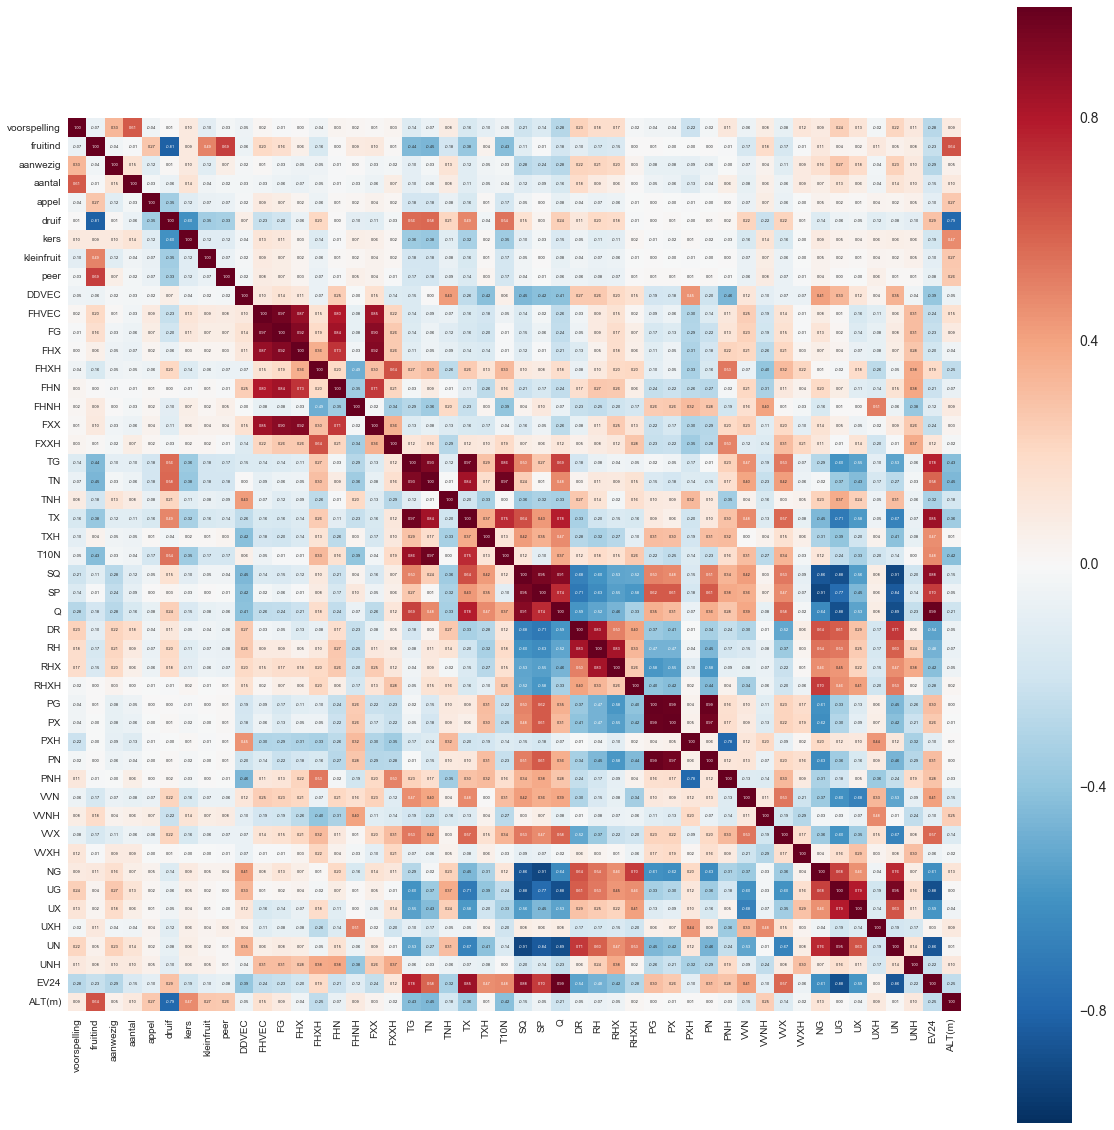

In [18]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches

cols = ['voorspelling','fruitind','aanwezig','aantal', 'appel', 'druif', 'kers', 'kleinfruit','peer','DDVEC','FHVEC', 'FG', 'FHX','FHXH','FHN','FHNH','FXX','FXXH','TG', 'TN','TNH','TX','TXH','T10N','SQ','SP','Q','DR','RH','RHX','RHXH','PG','PX','PXH','PN','PNH','VVN','VVNH','VVX','VVXH','NG','UG','UX','UXH','UN','UNH','EV24','ALT(m)']
cm = np.corrcoef(df_merged[cols].values, rowvar=0)
sns.set(font_scale=1.4)
hm = sns.heatmap(cm,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 4},
    yticklabels=cols,
    xticklabels=cols)
plt.show()

Wij denken dat de volgende factoren invloed zullen hebben op de voorspelling voor de aanwezigheid van de fruitvlieg.

UX = Maximale relatieve vochtigheid |
UN = minimale relative vochtigheid

FHN = Laagste windsnelheid |
FHX = Hoogste windsnelheid

TN = Minimum temperatuur |
TX = Maximum temperatuur

Zoals we nu kunnen zien in de heatmap zijn er een aantal factoren die correleren met het aanwezigheids veld waaronder:
EV24 -> UN -> UG -> UX -> NG -> DR -> RH -> RHX -> SQ -> SP -> Q -> TNH

Hieruit kunnen we concluderen dat van de geselecteerde factoren die wij zagen als belangrijk alleen maar de minimale en maximale relatieve vochtigheid invloed heeft.

## Linear Regression on Merged Dataset

In [19]:
df_merged.columns

Index(['aantal', 'appel', 'dag', 'datum', 'druif', 'fruitsoort', 'jaar',
       'kers', 'kleinfruit', 'lat', 'lon', 'maand', 'meting_id', 'peer', 'STN',
       'YYYYMMDD', 'DDVEC', 'FHVEC', 'FG', 'FHX', 'FHXH', 'FHN', 'FHNH', 'FXX',
       'FXXH', 'TG', 'TN', 'TNH', 'TX', 'TXH', 'T10N', 'T10NH', 'SQ', 'SP',
       'Q', 'DR', 'RH', 'RHX', 'RHXH', 'PG', 'PX', 'PXH', 'PN', 'PNH', 'VVN',
       'VVNH', 'VVX', 'VVXH', 'NG', 'UG', 'UX', 'UXH', 'UN', 'UNH', 'EV24',
       'LON(east)', 'LAT(north)', 'ALT(m)', 'NAME', 'afstand', 'aanwezig',
       'voorspelling', 'fruitind'],
      dtype='object')

In [20]:
from sklearn.cross_validation import train_test_split
X = df_merged[cols]
del X['aantal']
del X['aanwezig']
del X['voorspelling']
y = df_merged['aantal'].values
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, random_state=0
)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % 
    (r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train: 4206.263, test: 28540.228
R^2 train: 0.242, test: 0.111


In [21]:
df_merged

,aantal,appel,dag,datum,druif,fruitsoort,jaar,kers,kleinfruit,lat,...,UNH,EV24,LON(east),LAT(north),ALT(m),NAME,afstand,aanwezig,voorspelling,fruitind
4,0.0,0.0,01,2015-08-01,1.0,druif,2015,0.0,0.0,52.348315,...,13.0,38.0,5.520,52.458,-3.7,LELYSTAD,23.853730,0,0.0,0
18,0.0,0.0,16,2015-07-16,1.0,druif,2015,0.0,0.0,52.198608,...,14.0,49.0,5.873,52.056,48.2,DEELEN,18.302194,0,0.0,0
19,0.0,0.0,01,2015-07-01,1.0,druif,2015,0.0,0.0,52.198608,...,15.0,59.0,5.873,52.056,48.2,DEELEN,18.302194,0,0.0,0
24,0.0,0.0,01,2015-08-01,1.0,druif,2015,0.0,0.0,52.198608,...,11.0,40.0,5.873,52.056,48.2,DEELEN,18.302194,0,0.0,0
35,0.0,0.0,01,2015-07-01,1.0,druif,2015,0.0,0.0,51.414131,...,16.0,57.0,3.596,51.442,8.0,VLISSINGEN,15.911706,0,0.0,0
36,0.0,0.0,01,2015-08-01,1.0,druif,2015,0.0,0.0,51.414131,...,14.0,42.0,3.596,51.442,8.0,VLISSINGEN,15.911706,0,0.0,0
38,0.0,0.0,16,2015-07-16,1.0,druif,2015,0.0,0.0,51.414131,...,12.0,44.0,3.596,51.442,8.0,VLISSINGEN,15.911706,0,0.0,0
43,3.0,0.0,01,2015-07-01,1.0,druif,2015,0.0,0.0,52.113207,...,15.0,59.0,5.873,52.056,48.2,DEELEN,25.001994,1,0.0,0
46,61.0,0.0,16,2015-09-16,1.0,druif,2015,0.0,0.0,52.113207,...,24.0,7.0,5.873,52.056,48.2,DEELEN,25.001994,1,2.0,0
56,0.0,0.0,01,2015-07-01,1.0,druif,2015,0.0,0.0,51.495140,...,13.0,58.0,5.707,51.659,22.0,VOLKEL,32.173511,0,0.0,0


In [22]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print("Accuracy on training set:")
    print(clf.score(X_train, y_train))
    print("Accuracy on testing set:")
    print(clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(metrics.confusion_matrix(y_test, y_pred))

In [ ]:
from sklearn.cross_validation import train_test_split
X = df_merged[cols]
print(X.columns)
del X['aantal']
del X['aanwezig']
del X['voorspelling']
del X['kers']
del X['druif']
del X['appel']
del X['peer']
del X['kleinfruit']
del X['DR']
del X['VVX']
del X['FHX']
del X['PN']
y = df_merged['aanwezig'].values
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, random_state=0
)

svc = SVC(kernel='linear')

cv = KFold(len(y_train), 5, shuffle=True, random_state=0)
scores = cross_val_score(svc, X_train, y_train, cv=cv)
average = (np.average(scores) * 100)

train_and_evaluate(svc, X_train, X_test, y_train, y_test)

Index(['voorspelling', 'fruitind', 'aanwezig', 'aantal', 'appel', 'druif',
       'kers', 'kleinfruit', 'peer', 'DDVEC', 'FHVEC', 'FG', 'FHX', 'FHXH',
       'FHN', 'FHNH', 'FXX', 'FXXH', 'TG', 'TN', 'TNH', 'TX', 'TXH', 'T10N',
       'SQ', 'SP', 'Q', 'DR', 'RH', 'RHX', 'RHXH', 'PG', 'PX', 'PXH', 'PN',
       'PNH', 'VVN', 'VVNH', 'VVX', 'VVXH', 'NG', 'UG', 'UX', 'UXH', 'UN',
       'UNH', 'EV24', 'ALT(m)'],
      dtype='object')


# Random Forest genereren om te kijken naar de validiteit van Features

In [ ]:
names = X.columns.values
rf = RandomForestRegressor()
rf.fit(X,y)
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names),reverse=True))

Zoals hierboven vertoond wordt zetten we nu alle features neer in de volgorde van belang. In de heatmap trokken we enige andere conclussies maar deze waren redelijk onduidelijk.
Q is belangrijk dit staat voor Straling en de TN en TG staan voor de temperatuur deze schijnen goed belangrijk te zijn.

In [ ]:
#TG       = Etmaalgemiddelde temperatuur (in 0.1 graden Celsius)
#TN       = Minimum temperatuur (in 0.1 graden Celsius)
#Q        = Globale straling (in J/cm2)